1. environment setups

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers

2. furth environment setups and loading functions

In [ ]:
###import that needs some processing time
import transformers as tformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import clip
from google.colab import drive
drive.mount('/content/drive')
import os
import pickle
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import datetime
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')
import h5py
os.chdir('/content/drive/MyDrive/Dataset')
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

classes = ["Drama", "Comedy", "Romance", "Thriller", "Crime", "Action", "Adventure", "Horror", "Documentary", "Mystery", "Sci-Fi", "Music", "Fantasy", "Family", "Biography", "War", "History", "Animation", "Musical", "Western", "Sport", "Short", "Film-Noir"]
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_text_inputs = torch.cat([clip.tokenize(f"a poster of a {c} movie") for c in classes]).to(device)

def load_8k_set():
  pickle_filename = '8k_dataset.pkl'
  with open(pickle_filename, 'rb') as file:
      small_set = pickle.load(file)
  # print('test small_set!!!')
  # print(small_set[0])
  # print(type(small_set[0]))

  # print('pass!!!')
  batch_size = 64

  processed_data8k = []
  test_debug = []
  # print(small_set[10])
  # print(small_set[0])
  # print(small_set[0]['image'])
  # print(type(small_set[0]['image']))
  for movie in small_set:
      #this 8k_set dataset lacks the process to convert image into PIL image，so we do this below
      image = movie['image']
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image.astype(np.uint8))
      # plt.figure()
      # plt.imshow(image)
      # plt.title('the posters used for preprocess')
      #preprocess image
      processed_img = preprocess(image)
      genre_label = torch.tensor(movie['genre'])
      img_plot_genre = (processed_img, movie['plot'], genre_label)
      processed_data8k.append(img_plot_genre)
  # create train loader
  train_loader = DataLoader(processed_data8k[0:7000], batch_size=batch_size, shuffle=True)
  # create test loader
  test_loader = DataLoader(processed_data8k[7000:8000], batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

###########################text model(BERT)###########################################
class DistilBert(nn.Module):
    def __init__(self, c_in):
        super(DistilBert, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(c_in, 512, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(512, 320, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(320, 120, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(120, 23, bias=True),
            nn.Sigmoid()
        )
        self.BERTog = model_class.from_pretrained(pretrained_weights)
        # self.BERTog = AutoModelForSequenceClassification.from_pretrained("zayedupal/movie-genre-prediction_distilbert-base-uncased")
        self.fc = self.fc.to(device)
        self.BERTog = self.BERTog.to(device)
        # freezing BERTog parameter
        for param in self.BERTog.parameters():
            param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        last_hidden_states = self.BERTog(input_ids, attention_mask=attention_mask)

        features = last_hidden_states[0][:,0,:]
        # print("!!!!features is", features)
        x = self.fc(features)
        return x
#######################################################################
###############################visual model(CLIP)############################
class MultiModalModel(nn.Module):
    def __init__(self):
        super(MultiModalModel, self).__init__()

        self.adapter = Adapter(512, 4).to(clip_model.dtype)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype
        self.clip_model = clip_model
        self.bn = nn.BatchNorm1d(23)  # 添加批标准化层
        self.bn = self.bn.to(device)
        for param in self.clip_model.parameters():
            param.requires_grad = False
    def forward(self, img, text_inputs):

        img = img.to(device)
        text_inputs = text_inputs.to(device)
        image_features = self.clip_model.encode_image(img.type(self.dtype))
        text_features = self.clip_model.encode_text(text_inputs)
        image_features = image_features.to(torch.float32)
        text_features = text_features.to(torch.float32)
        # image_features = self.bn(image_features)
        # text_features = self.bn(text_features)
        x = self.adapter(image_features)
        y = self.adapter(text_features)
        ratio = 0.2
        image_features = ratio * x + (1 - ratio) * image_features
        text_features = ratio * y + (1 - ratio) * text_features

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # print(image_features)
        # print(text_features)
        logit_scale = self.logit_scale.exp()
        logits = (100 * image_features @ text_features.t()).softmax(dim=-1)
        # logits = (logit_scale * logit_scale * image_features @ text_features.t())

        logits = self.bn(logits)
        logits = torch.sigmoid(logits)
        # logits = torch.softmax(logits)
        # print(logits)
        # logits = (100 * image_features @ text_features.T).softmax(dim=-1)

        return logits


class Adapter(nn.Module):
    def __init__(self, c_in, reduction=4):
        super(Adapter, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(c_in, c_in // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c_in // reduction, c_in, bias=False),
            nn.ReLU(inplace=True)
        )
        self.fc = self.fc.to(device)

    def forward(self, x):
        # x = x.to(device)
        x = self.fc(x)
        return x

################################################################################

##########################GMU model############################################
class GMU(nn.Module):
    def __init__(self):
        super(GMU, self).__init__()

        self.Distil_BERT = DistilBert(768).to(torch.float32)
        self.CLIP_Adapter = MultiModalModel().to(torch.float32)
        # loading previous check points
        CLIP_Adapter_checkpoint_path = 'model_checkpoint_Adapter(with_sigmoid+BCE)_50epoch.pth'
        Distil_BERT_checkpoint_path = 'model_checkpoint_Text_8kTrain_3rd(best).pth'
        # if os.path.exists(CLIP_Adapter_checkpoint_path):
        #     self.load_state_dict(torch.load(CLIP_Adapter_checkpoint_path))
        #     print(f"CLIP_Adapter Model parameters sucessfully loaded from '{CLIP_Adapter_checkpoint_path}'")
        # if os.path.exists(Distil_BERT_checkpoint_path):
        #     self.load_state_dict(torch.load(Distil_BERT_checkpoint_path))
            # print(f"Distil_BERT Model parameters sucessfully loaded from '{Distil_BERT_checkpoint_path}'")
        self.Distil_BERT = self.Distil_BERT.to(device)
        self.CLIP_Adapter = self.CLIP_Adapter.to(device)
        self.sigma = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.Wz = nn.Sequential(
            nn.Linear(1024, 400, bias=False),#img_features is 512, as well as (input_ids)
            nn.ReLU(inplace=True),
            nn.Linear(400, 20, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(20, 1, bias=False)
        ).to(torch.float32)
        self.Wz = self.Wz.to(device)
    def forward(self, img, clip_text_inputs, input_ids, attention_mask):
        img = img.to(device)
        clip_text_inputs = clip_text_inputs.to(device)
        input_ids = input_ids.to(device)
        # print('forward input img shape is:',img.shape)
        # print('forward input_ids shape is:',input_ids.shape)
        ##########text part#######################
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        text_output = self.Distil_BERT(input_ids, attention_mask=attention_mask)
        ###########visual part###############################
        visual_output = self.CLIP_Adapter(img, clip_text_inputs)
        #################################################
        h_t = self.tanh(text_output)
        h_v = self.tanh(visual_output)

        #########concatenate two modal inputs#############
        img_features = (clip_model.encode_image(img)).to(torch.float32)
        concatenated_inputs = torch.cat((img_features, input_ids), dim=1)
        # print('after concatenated, shape is:',concatenated_inputs.shape)
        # print('forward input img shape is:',img_features.shape)
        # print('forward input_ids shape is:',input_ids.shape)
        z = self.Wz(concatenated_inputs)
        z = torch.sigmoid(z)
        h = z * h_v + (1-z) * h_t
        return h

# #######################Training function####################################
def train_model(model, train_loader, optimizer, criterion, num_epochs, writer):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for (img, plots, genre_labels) in train_loader:
            optimizer.zero_grad()
            plots = pd.Series(plots)
            tokenized = plots.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
            #truncation
            max_sequence_length = 512
            tokenized = tokenized.apply(lambda seq: seq[:max_sequence_length])
            max_len = 512
            for i in tokenized.values:
                if len(i) > max_len:
                    max_len = len(i)

            padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

            attention_mask = np.where(padded != 0, 1, 0)
            input_ids = torch.tensor(padded)
            attention_mask = torch.tensor(attention_mask)

            outputs = model(img, clip_text_inputs, input_ids, attention_mask)
            labels = torch.tensor(genre_labels)
            labels = labels.to(device)
            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)

            labels = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        writer.add_scalar('Training Loss', avg_epoch_loss, epoch+1)  # 添加损失值到 TensorBoard

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    writer.close()



#################################main function###################################
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (tformer.DistilBertModel, tformer.DistilBertTokenizer, 'distilbert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_og = model_class.from_pretrained(pretrained_weights)

# training setups
image_feature_dim = 512
text_feature_dim = 512
num_classes = 23
# hidden_dim = ...
num_epochs = 7
learning_rate = 0.00001

# # load data
# train_loader, test_loader = load_8k_set()
###################float32 conversion(otherwise GPU will crash)#################
model = GMU().to(torch.float32)

for param in model.parameters():
    param.data = param.data.to(torch.float32)




3. Demonstration, everytime you run it, it draws a random sample from the testing set and feed it into our Fusion model.

The prediction results and the Ground truth label, along with the poster image and the plot description will be presented together.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
processed_poster size is: torch.Size([1, 3, 224, 224])
clip_text_inputs size is: torch.Size([23, 77])
input_ids is: torch.Size([1, 512])
plot description is: A half-shark, half-octopus (sharktopus) creature has been scientifically created causes a whole lot of terror in the Dominican Republic while a scientist who helped created it tries to capture and kill it. All while this is happening, a wolf and whale mix (whalewolf) is trying to gain power over the territory and steal it from the sharktopus.
(groundtruth)movie genre is: ['Comedy', 'Horror', 'Sci-Fi']
GMU prediction is: ['Horror']


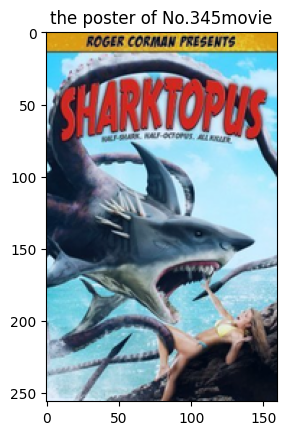

In [ ]:
def binary2text(vector):
    classes = ["Drama", "Comedy", "Romance", "Thriller", "Crime", "Action", "Adventure", "Horror", "Documentary",
               "Mystery", "Sci-Fi", "Music", "Fantasy", "Family", "Biography", "War", "History", "Animation",
               "Musical", "Western", "Sport", "Short", "Film-Noir"]
    predicted_classes = []


    for i in range(23):

        if vector[i] == 1:
            predicted_classes.append(classes[i])

    return predicted_classes

import random
from sklearn.metrics import f1_score
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Dataset')
threshold = 0.5
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer

def binarize_predictions(predictions, threshold):
    binary_predictions = []
    for tensor in predictions:
        binary_tensor = (tensor >= threshold).int()
        binary_predictions.append(binary_tensor)
    return binary_predictions
model_checkpoint_path = 'model_checkpoint_GMU_4th(+15epoch).pth' # loading the best performing weights
#to use this demo, first you hava to download the checkpoint first(or put it in Google Onedrive), and load it from there.###
model = GMU().to(torch.float32)

model.load_state_dict(torch.load(model_checkpoint_path))
model.to(device)
model.eval()

pickle_filename = '8k_dataset.pkl'
# loading file from pkl
with open(pickle_filename, 'rb') as file:
    small_set = pickle.load(file)
small_set = small_set[7000:8000]
random_index = random.randint(0, len(small_set)-1)

image = small_set[random_index]['image']
poster = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
poster = Image.fromarray(poster.astype(np.uint8))
processed_poster = preprocess(poster)
genre_label = torch.tensor(small_set[random_index]['genre'])
plot = small_set[random_index]['plot']

plots = pd.Series(plot)
tokenized = plots.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_sequence_length = 512
tokenized = tokenized.apply(lambda seq: seq[:max_sequence_length])
max_len = 512
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

processed_poster = processed_poster.unsqueeze(0)
# input_ids = input_ids.unsqueeze(0)
# attention_mask = attention_mask.unsqueeze(0)

print('processed_poster size is:', processed_poster.shape)
print('clip_text_inputs size is:', clip_text_inputs.shape)
print('input_ids is:', input_ids.shape)
# print('attention_mask is:', attention_mask.shape)
outputs = model(processed_poster, clip_text_inputs, input_ids, attention_mask)
# test_predictions.append(outputs)
# print(outputs)
test_predictions = binarize_predictions(outputs, threshold)
# print(test_predictions)
# print('genre_label is:', genre_label)
# print('type of genre_label is:', type(genre_label))
test_predictions = test_predictions[0]
test_predictions_text = binary2text(test_predictions)
genre_label_text = binary2text(genre_label)

plt.figure()
plt.imshow(poster)
plt.title('the poster of No.' + str(random_index) + 'movie')
print('plot description is:',plot)
print('(groundtruth)movie genre is:', genre_label_text)
print('GMU prediction is:', test_predictions_text)


def load_8k_set():

  batch_size = 64

  processed_data8k = []
  test_debug = []
  for movie in small_set:

      image = movie['image']
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image.astype(np.uint8))

      #preprocess image
      processed_img = preprocess(image)
      genre_label = torch.tensor(movie['genre'])
      img_plot_genre = (processed_img, movie['plot'], genre_label)
      processed_data8k.append(img_plot_genre)

  train_loader = DataLoader(processed_data8k[0:7000], batch_size=batch_size, shuffle=True)

  test_loader = DataLoader(processed_data8k[7000:8000], batch_size=batch_size, shuffle=False)
  return train_loader, test_loader


#for (img, plots, genres_labels) in test_loader:

